Train size: 16000, Test size: 4000

📊 Test Set Evaluation:
✅ Accuracy:  0.9337
✅ Precision: 0.8856
✅ Recall:    0.9970
✅ F1 Score:  0.9380
✅ MCC:       0.8744
✅ Kappa:     0.8674

📑 Classification Report:
              precision    recall  f1-score   support

        Real       1.00      0.87      0.93      1989
        Fake       0.89      1.00      0.94      2011

    accuracy                           0.93      4000
   macro avg       0.94      0.93      0.93      4000
weighted avg       0.94      0.93      0.93      4000



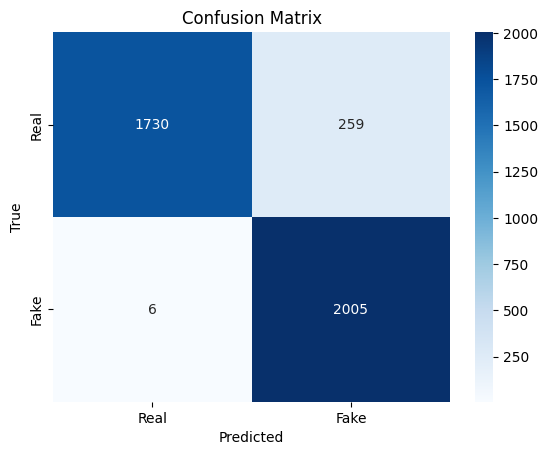

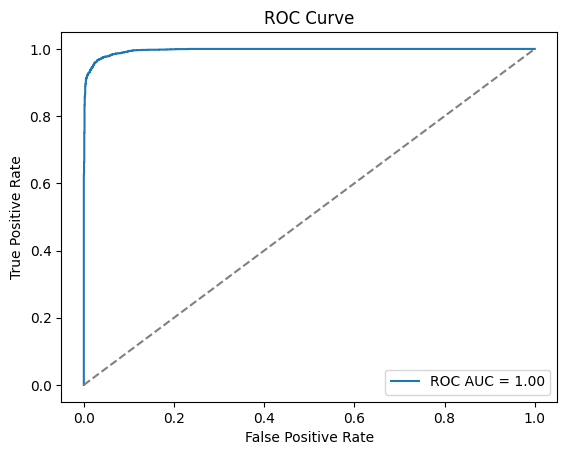

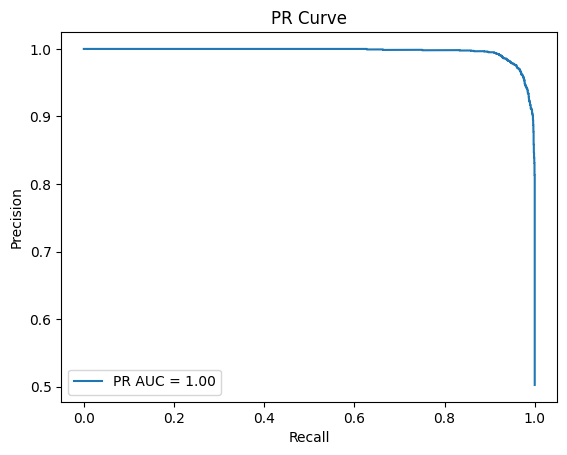

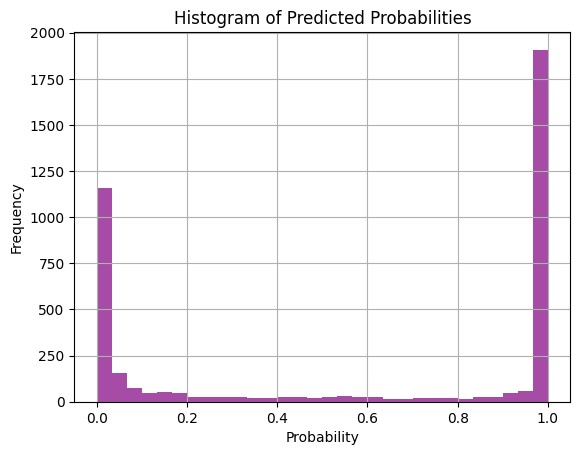

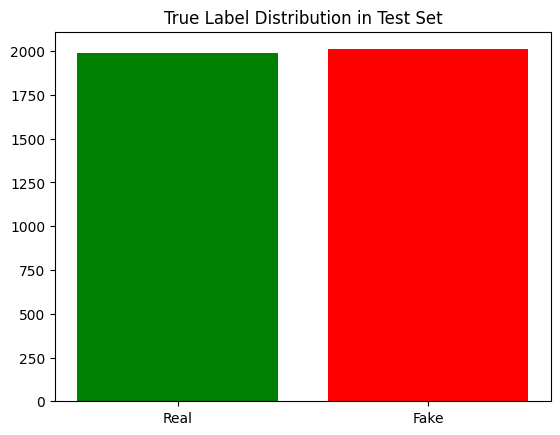

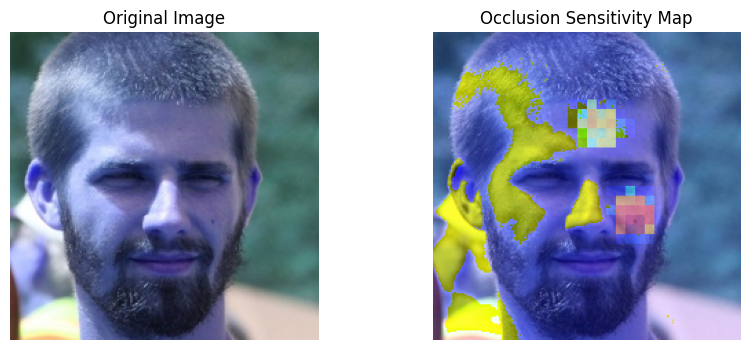

In [3]:
# ====== Import Libraries ======
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc, classification_report,
    precision_recall_curve, matthews_corrcoef, cohen_kappa_score
)
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2

# ====== Device ======
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ====== SEBlock ======
class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.fc = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(channel, channel // reduction, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channel // reduction, channel, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        scale = self.fc(x)
        return x * scale

# ====== Encoder ======
class GenConCNNEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            SEBlock(64),

            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            SEBlock(128),

            nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(),
            SEBlock(256),

            nn.AdaptiveAvgPool2d((16, 16))
        )

        backbone = models.resnet18(pretrained=True)
        self.global_conv = nn.Sequential(*list(backbone.children())[:-1])
        for param in self.global_conv.parameters():
            param.requires_grad = True

    def forward(self, x):
        local_feat = self.cnn(x)
        global_feat = self.global_conv(x)
        global_feat = global_feat.view(x.size(0), -1)
        return local_feat, global_feat

def load_image(img_path):
    image = Image.open(img_path).convert("RGB")
    image_tensor = transform(image)
    return image_tensor, np.array(image.resize((224, 224)))

# ====== Full Model ======
class GenConCNNFullModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = GenConCNNEncoder()
        self.classifier = nn.Sequential(
            nn.Linear(256 * 16 * 16 + 512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 1)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        local_feat, global_feat = self.encoder(x)
        flat_local = local_feat.view(x.size(0), -1)
        combined = torch.cat([flat_local, global_feat], dim=1)
        cls_out = self.classifier(combined)
        recon = self.decoder(local_feat)
        return cls_out, recon

# ====== Occlusion Sensitivity ======
def occlusion_sensitivity(model, image_tensor, block_size=16, stride=8):
    model.eval()
    original_output, _ = model(image_tensor.unsqueeze(0).to(device))
    original_prob = torch.sigmoid(original_output).item()

    sensitivity_map = np.zeros((image_tensor.shape[1], image_tensor.shape[2]))

    for i in range(0, image_tensor.shape[1] - block_size + 1, stride):
        for j in range(0, image_tensor.shape[2] - block_size + 1, stride):
            occluded_image = image_tensor.clone().detach()
            occluded_image[:, i:i+block_size, j:j+block_size] = 0
            occluded_output, _ = model(occluded_image.unsqueeze(0).to(device))
            occluded_prob = torch.sigmoid(occluded_output).item()
            sensitivity_map[i:i+block_size, j:j+block_size] = np.abs(original_prob - occluded_prob)

    return sensitivity_map

def show_occlusion_sensitivity(image_tensor, sensitivity_map, orig_img):
    sensitivity_map = cv2.resize(sensitivity_map, (orig_img.shape[1], orig_img.shape[0]))
    sensitivity_map_normalized = (sensitivity_map - sensitivity_map.min()) / (sensitivity_map.max() - sensitivity_map.min())
    heatmap = cv2.applyColorMap(np.uint8(255 * sensitivity_map_normalized), cv2.COLORMAP_JET)
    superimposed = heatmap * 0.4 + orig_img

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(orig_img[:, :, ::-1])
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(superimposed[:, :, ::-1].astype(np.uint8))
    plt.title("Occlusion Sensitivity Map")
    plt.axis('off')
    plt.show()

# ====== Dataset ======
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

DATASET_PATH = 'E:/Project_1/archive/real_vs_fake/real-vs-fake/test'
full_dataset = datasets.ImageFolder(root=DATASET_PATH, transform=transform)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

print(f"Train size: {len(train_dataset)}, Test size: {len(test_dataset)}")

# ====== Load Model ======
model = GenConCNNFullModel().to(device)
model.load_state_dict(torch.load("E:/Project_1/best_model.pt", map_location=device))
model.eval()

# ====== Evaluation Function ======
def evaluate(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    all_probs = []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits, _ = model(x)
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).int().cpu().numpy()
            all_preds.extend(preds.reshape(-1))
            all_labels.extend(y.cpu().numpy())
            all_probs.extend(probs.squeeze().cpu().numpy())
    return np.array(all_labels), np.array(all_preds), np.array(all_probs)

# ====== Run Evaluation ======
true_labels, pred_labels, pred_probs = evaluate(model, test_loader)

# ====== Metrics ======
acc = accuracy_score(true_labels, pred_labels)
prec = precision_score(true_labels, pred_labels)
rec = recall_score(true_labels, pred_labels)
f1 = f1_score(true_labels, pred_labels)
mcc = matthews_corrcoef(true_labels, pred_labels)
kappa = cohen_kappa_score(true_labels, pred_labels)

print("\n📊 Test Set Evaluation:")
print(f"✅ Accuracy:  {acc:.4f}")
print(f"✅ Precision: {prec:.4f}")
print(f"✅ Recall:    {rec:.4f}")
print(f"✅ F1 Score:  {f1:.4f}")
print(f"✅ MCC:       {mcc:.4f}")
print(f"✅ Kappa:     {kappa:.4f}")

print("\n📑 Classification Report:")
print(classification_report(true_labels, pred_labels, target_names=["Real", "Fake"]))

# ====== Confusion Matrix ======
def plot_evaluation(true_labels, pred_labels, pred_probs):
    # Confusion Matrix
    cm = confusion_matrix(true_labels, pred_labels)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(true_labels, pred_probs)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(true_labels, pred_probs)
    pr_auc = auc(recall, precision)
    plt.figure()
    plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.2f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('PR Curve')
    plt.legend()
    plt.show()

    # Histogram
    plt.hist(pred_probs, bins=30, alpha=0.7, color='purple')
    plt.title('Histogram of Predicted Probabilities')
    plt.xlabel('Probability')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

    # Class distribution
    labels = ['Real', 'Fake']
    unique, counts = np.unique(true_labels, return_counts=True)
    plt.bar(labels, counts, color=['green', 'red'])
    plt.title('True Label Distribution in Test Set')
    plt.show()


# ====== Occlusion Sensitivity Visualization ======
img_path = 'archive/real_vs_fake/real-vs-fake/test/real/69869.jpg'
plot_evaluation(true_labels, pred_labels, pred_probs)
image_tensor, orig_img = load_image(img_path)
image_tensor = image_tensor.to(device)

sensitivity_map = occlusion_sensitivity(model, image_tensor)
show_occlusion_sensitivity(image_tensor.cpu(), sensitivity_map, orig_img)